# 1. Carregar os datasets

Começamos fazendo os imports necessários e carregando os datasets que iremos usar.

In [1]:
import json
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.neighbors import KernelDensity
from IPython.display import display

In [2]:
# Abrimos os arquivos json.
with open("datasets/BASE B/students.json", "r") as read_file:
    students = json.load(read_file)
    
with open("datasets/BASE B/sessions.json", "r") as read_file:
    sessions = json.load(read_file)
    
with open("datasets/BASE B/subjects.json", "r") as read_file:
    subjects = json.load(read_file)
    
with open("datasets/BASE B/questions.json", "r") as read_file:
    questions = json.load(read_file)
    
with open("datasets/BASE B/answers.json", "r") as read_file:
    answers = json.load(read_file)
    
with open("datasets/BASE B/fileViews.json", "r") as read_file:
    fileViews = json.load(read_file)
    
with open("datasets/BASE B/premium_payments.json", "r") as read_file:
    premium_payments = json.load(read_file)
    
with open("datasets/BASE B/premium_cancellations.json", "r") as read_file:
    premium_cancellations = json.load(read_file)
    
data_dict = {'students': students,
             'sessions': sessions,
             'subjects': subjects,
             'questions': questions,
             'answers': answers,
             'fileViews': fileViews,
             'premium_payments': premium_payments,
             'premium_cancellations': premium_cancellations}
label_list = ['students', 'sessions', 'subjects', 'questions', 'answers', 'fileViews', 'premium_payments', 'premium_cancellations']

In [3]:
def get_all_keys(data):
    """
    Given a dictionary of data, A is the set of keys to be used as features in our dataframes.
    
    Parameters:
    data: list
        List of data extracted from the json file.
        
    Returns:
    A: set
    """
    
    m = len(data)
    A = set(data[0].keys())
    for i in range(m-1):
        A = A.union(set(data[i+1].keys()))
    return list(A)

In [4]:
# Criamos um dicionário contendo as features de cada dataset.
features_dict = {}
for x in label_list:
    features_dict[x] = get_all_keys(data_dict[x])

Os dicionários **data_dict** e **features_dict** contém todos os datasets e features dos datasets, respectivamente. A lista **label_list** contém os nomes dos datasets. Abaixo, iremos criar os dataframes correspondentes aos datasets, para então podermos usar as ferramentas do [Pandas](https://pandas.pydata.org/).

In [5]:
def missing_values(data, features):
    """
    Where there is no data a NaN value is introduced. This will help us to create dataframes.
    
    Parameters:
    data: list
        List of data extracted from the json file.
    feature: list
        List with the features of the data.
        
    Returns:
    data: list
    """
    
    m = len(data)    
    for i in range(m):
        for x in features:
            if x not in data[i].keys():
                data[i][x] = np.NaN                
    return data

In [6]:
for x in label_list:
    data_dict[x] = missing_values(data_dict[x], features_dict[x])

In [7]:
def initialize_dataframe(data, features):
    m, n = len(data), len(features)
    df = pd.DataFrame(np.zeros((m, n)), columns=features)
    for x in features:
        df[x] = [data[i][x] for i in range(m)]
    return df

In [8]:
# Inicializamos os dataframes e os colocamos dentro de um dicionário.
df_dict = {}
for x in label_list:
    data = data_dict[x]
    features = features_dict[x]
    df_dict[x] = initialize_dataframe(data, features) 

Os dataframes, que estão no dicionário **df_dict**, contém diversas datas no formato string. Para mudar isso, iremos colocar as datas no formato datetime. 

In [9]:
def str_to_timestamp(date):
    date = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f')
    date = datetime.datetime.strptime(str(date.year) + '-' + str(date.month) + '-' + str(date.day), '%Y-%m-%d')
    return date

In [10]:
def str_to_timestamp_2(date):
    date = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    return date

In [11]:
# Arrumamos o formato das datas.
df_dict['students']['RegisteredDate'] = df_dict['students']['RegisteredDate'].apply(str_to_timestamp)
df_dict['sessions']['SessionStartTime'] = df_dict['sessions']['SessionStartTime'].apply(str_to_timestamp_2)
df_dict['subjects']['FollowDate'] = df_dict['subjects']['FollowDate'].apply(str_to_timestamp)
df_dict['questions']['QuestionDate'] = df_dict['questions']['QuestionDate'].apply(str_to_timestamp)
df_dict['answers']['AnswerDate'] = df_dict['answers']['AnswerDate'].apply(str_to_timestamp)
df_dict['fileViews']['ViewDate'] = df_dict['fileViews']['ViewDate'].apply(str_to_timestamp)
df_dict['premium_payments']['PaymentDate'] = df_dict['premium_payments']['PaymentDate'].apply(str_to_timestamp)
df_dict['premium_cancellations']['CancellationDate'] = df_dict['premium_cancellations']['CancellationDate'].apply(str_to_timestamp)

# Com exceção do dataframe 'student', a coluna das ids sempre está com a label 'StudentId'. Aqui nós arrumamos isso.
df_dict['students'] = df_dict['students'].rename(columns={'Id': 'StudentId'})

Abaixo, temos uma visão geral de como são os datasets com os quais iremos trabalhar.

In [12]:
for x in df_dict.keys():
    print(x)
    display(df_dict[x].head())
    print('\n\n\n')

students


,UniversityName,SignupSource,StudentId,StudentClient,CourseName,RegisteredDate,State,City
0,PUC-RIO,Email,12970655,NaN,Administração,2012-05-29,Rio de Janeiro,NaN
1,UFF,Facebook,59873654,NaN,Direito do Trabalho e Segurança Social,2012-09-03,Rio de Janeiro,Rio de Janeiro
2,UNB,Facebook,3664695,NaN,Enfermagem,2012-09-10,Distrito Federal,NaN
3,UERJ,Facebook,15207697,NaN,Engenharia de Produção Mecânica,2012-09-05,Rio de Janeiro,Resende
4,UFU,Facebook,36988693,NaN,Engenharia Elétrica,2012-10-15,NaN,NaN






sessions


,StudentClient,StudentId,SessionStartTime
0,Website,12970655,2017-02-20 14:51:37
1,Website,12970655,2017-02-22 14:04:34
2,Website,12970655,2017-02-23 13:46:14
3,Website,12970655,2017-02-23 14:52:24
4,Website,12970655,2017-03-03 20:47:21






subjects


,StudentId,FollowDate,SubjectName
0,12970655,2015-09-12,Disciplina Integradora II
1,12970655,2015-09-12,Pesquisa Operacional
2,12970655,2016-06-07,Cálculo I
3,12970655,2015-09-12,Introdução à Administração
4,12970655,2015-09-12,Contabilidade Aplicada à Administração






questions


,StudentId,QuestionDate,StudentClient,QuestionSnippet
0,12970655,2013-09-04,NaN,O que é mais importante para um projeto: escop...
1,12970655,2013-09-04,NaN,Você pode ter um negócio/produto bem sucedido ...
2,12970655,2013-10-30,NaN,Custos com consultoria para planejar um projet...
3,12970655,2013-10-30,NaN,CAPEX: investimento em consultoria entra como ...
4,12970655,2013-10-30,NaN,Custos com consultoria para planejar um projet...






answers


,StudentId,AnswerDate,StudentClient,AnswerSnippet
0,12970655,2013-08-30,NaN,"<p>Vou tentar <span style=""text-decoration: un..."
1,12970655,2013-09-04,NaN,<p>O <strong>centil</strong> divide algo em 10...
2,12970655,2013-09-05,NaN,<p>Ou ser&aacute; que o problema que esses pro...
3,12970655,2013-09-04,NaN,<p>Excelente pergunta! Abaixo est&atilde;o as ...
4,12970655,2013-11-12,NaN,<p>Vamos supor que voc&ecirc; se compromete a ...






fileViews


,StudentId,ViewDate,FileName,Studentclient
0,12970655,2017-02-23,Exercicios Resolvidos do Halliday sobre Rotaçã...,Website
1,12970655,2017-02-23,Exercicios Resolvidos do Halliday sobre Rotaçã...,Website
2,12970655,2017-05-25,CALCULO I,Website
3,12970655,2017-05-25,CALCULO I,Website
4,12970655,2017-05-25,CALCULO I,Website






premium_payments


,StudentId,PlanType,PaymentDate
0,12970655,Anual,2017-05-26
1,12970655,Anual,2018-05-26
2,12970655,Mensal,2016-07-21
3,12970655,Mensal,2016-08-21
4,12970655,Mensal,2016-09-21






premium_cancellations


,CancellationDate,StudentId
0,2016-05-05,34129668
1,2016-05-05,34129668
2,2016-05-20,82394932
3,2016-05-31,82942835
4,2016-06-01,85382416


# 2. Lifetime Value

Queremos analisar como o LTV varia com o tempo. O primeiro passo é saber o tempo que cada cliente passou pagando o plano premium. Iremos considerar este tempo em dias, como sendo a diferença entre a abertura e o cancelamento da conta premium. Este número será chamado de *student time*.

In [13]:
g1 = df_dict['premium_payments'].groupby('StudentId')
g1_groups = g1.groups

g2 = df_dict['premium_cancellations'].groupby('StudentId')
g2_groups = g2.groups

student_time = {}
missing = []
CancellationDates = {}

for x in g2_groups.keys():
    if x in g1_groups.keys():
        idx = list(g1_groups[x])
        d1 = min(df_dict['premium_payments'].loc[idx]['PaymentDate'])
        idx = list(g2.groups[x])
        d2 = max(df_dict['premium_cancellations'].loc[idx]['CancellationDate'])
        CancellationDates[x] = d2
        student_time[x] = (d2 - d1).days
    else:
        missing.append(x)
        
student_time_values = np.array(list(student_time.values()), dtype=np.int)
CancellationDates_values = np.array(list(CancellationDates.values()))
student_id = np.array(list(student_time.keys()))
student_time = pd.DataFrame(np.array([student_id, student_time_values, CancellationDates_values]).T, columns=['StudentId', 'StudentTime', 'CancellationDate'])
student_time.head()

,StudentId,StudentTime,CancellationDate
0,43621,5,2017-06-16
1,51498,20,2017-03-31
2,105540,7,2018-05-03
3,344828,15,2017-11-30
4,440239,295,2018-05-06


De modo análogo a um join do SQL, iremos usar o comando *merge* do Pandas para juntar o dataframe acima com o dataframe *students*, que contém as principais informações dos estudantes. A partir deste novo dataframe poderemos fazer diversas análises.

In [14]:
merged = df_dict['students'].merge(student_time, on='StudentId')
merged = merged[~pd.isnull(merged['State'])]
merged['StudentTime'] = merged['StudentTime'].astype(int)
merged.head()

,UniversityName,SignupSource,StudentId,StudentClient,CourseName,RegisteredDate,State,City,StudentTime,CancellationDate
0,UNICEUB,Facebook,67560047,NaN,Engenharia Civil,2012-09-10,Distrito Federal,Brasília,0,2017-11-22
1,UFSCAR,Facebook,94564987,NaN,Engenharia da Computação,2012-12-04,São Paulo,São Carlos,7,2017-06-08
2,ESTÁCIO,Facebook,49659124,NaN,Engenharia Ambiental,2012-11-04,Rio de Janeiro,NaN,27,2016-12-13
3,UFRJ,Facebook,75867885,NaN,Engenharia Química,2012-09-01,Rio de Janeiro,Rio de Janeiro,47,2018-02-28
4,UFAL,Facebook,76049200,NaN,Engenharia Química,2012-11-13,Maranhão,São Luís,29,2018-05-19


Primeiramente, iremos calcular a média de compras de planos premium pelos estudantes anualmente. Este valor é dado pela fórmula

$$\text{número médio de planos por ano} = \frac{\text{soma das compras no ano}}{\text{número de estudantes que fizeram compras no ano}}.$$

Obsevamos que este valor está sendo atualizado semanalmente na análise feita aqui. A ideia é basicamente usar a fórmula acima em uma certa data e os valores dos 365 dias anteriores. Além disso, como o plano mensal e anual possuem valores diferentes, iremos produzir dois dataframes de valores médios e depois iremos tirar a média entre eles para ser o valor médio final. 

In [16]:
# Inicialização de primeiras variáveis.
x = 'premium_cancellations'
d1, d2 = min(df_dict[x]['CancellationDate']), max(df_dict[x]['CancellationDate'])
dates = pd.date_range(d1, d2, freq='7D')
one_year = datetime.timedelta(days=365)

/home/felipe/anaconda3/envs/satelite2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


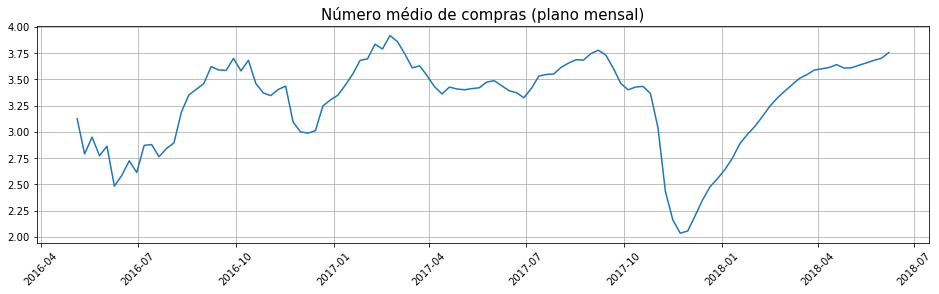

In [17]:
# Valor médio do plano mensal
mean_profit_mensal = pd.DataFrame(np.zeros((1, len(dates))), columns=dates)

x = 'premium_payments'
df_mensal = df_dict[x][df_dict[x]['PlanType']=='Mensal']
for d in dates:
    tmp_df = df_mensal[(df_mensal['PaymentDate'] > d-one_year) & (df_mensal['PaymentDate'] <= d)]
    num_students = len(tmp_df['StudentId'].unique())
    if num_students == 0:
        mean_profit_mensal[d] = 0
    else:
        mean_profit_mensal[d] = tmp_df.shape[0]/num_students
        
plt.figure(figsize=[16, 4])
plt.plot(dates, mean_profit_mensal.values[0])
plt.title('Número médio de compras (plano mensal)', fontsize=15)
plt.grid()
plt.xticks(rotation=45)
plt.show()

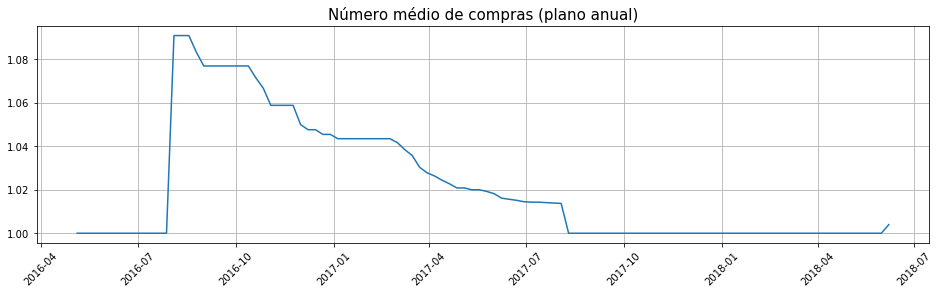

In [18]:
# Valor médio do plano anual
mean_profit_anual = pd.DataFrame(np.zeros((1, len(dates))), columns=dates)

x = 'premium_payments'
df_anual = df_dict[x][df_dict[x]['PlanType']=='Anual']
for d in dates:
    tmp_df = df_anual[(df_anual['PaymentDate'] > d-one_year) & (df_anual['PaymentDate'] <= d)]
    num_students = len(tmp_df['StudentId'].unique())
    if num_students == 0:
        mean_profit_anual[d] = 0
    else:
        mean_profit_anual[d] = tmp_df.shape[0]/num_students
        
plt.figure(figsize=[16, 4])
plt.plot(dates, mean_profit_anual.values[0])
plt.title('Número médio de compras (plano anual)', fontsize=15)
plt.grid()
plt.xticks(rotation=45)
plt.show()

Agora podemos usar os valores de client time para deduzir o tempo médio que um cliente fica no plano premium. Note que o início do gráfico abaixo é atípico, mas é apenas um artefato, refletindo o fato de haver poucos estudantes para tirar médias após o primeiro ano. O LTV é então obtido a partir da seguinte fórmula

$$LTV = \text{valor médio} \times \text{número médio de compras} \times \text{tempo médio de plano premium}.$$

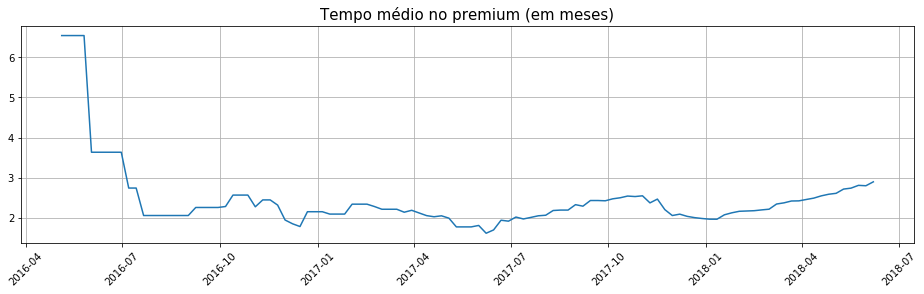

In [19]:
# Tempo médio em meses no plano premium 
mean_student_time = pd.DataFrame(np.zeros((1, len(dates))), columns=dates)

x = 'StudentTime'
for d in dates:
    tmp_df = merged[(merged['CancellationDate'] > d-one_year) & (merged['CancellationDate'] <= d)]
    num_students = len(tmp_df['StudentId'].unique())
    if num_students == 0:
        mean_student_time[d] = 0
    else:
        mean_student_time[d] = (12/365)*np.sum(tmp_df[x])/num_students
        
plt.figure(figsize=[16, 4])
plt.plot(dates, mean_student_time.values[0])
plt.title('Tempo médio no premium (em meses)', fontsize=15)
plt.grid()
plt.xticks(rotation=45)
plt.show()

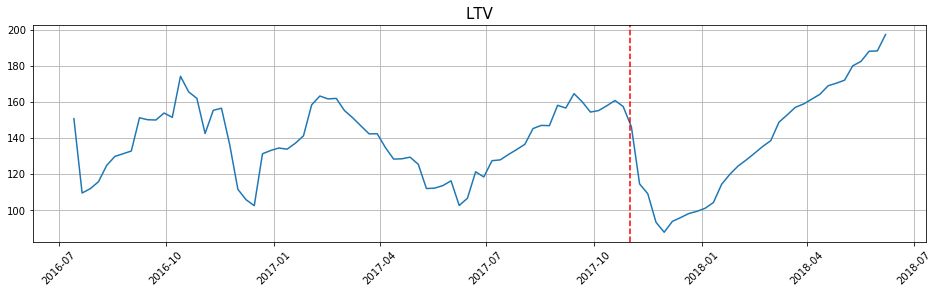

In [20]:
# LTV final
date = datetime.datetime.strptime('2017-11-01', '%Y-%m-%d')
LTV = (29.9*mean_profit_mensal*mean_student_time + 23.9*mean_profit_anual*mean_student_time)/2
        
plt.figure(figsize=[16, 4])
# Iremos omitir as primeiras entradas, pois elas apresentam comportamento atípico já observado.
plt.plot(dates[10:], LTV.values[0][10:])
plt.axvline(x=date, linestyle='--', color='red')
plt.title('LTV', fontsize=15)
plt.grid()
plt.xticks(rotation=45)
plt.show()

**A respeito da questão 2:** Assim que occoreu a mudança, o LTV sofreu uma forte queda seguida de um constante crescimento. Abaixo, podemos observar que a mudança de fato foi seguida de um aumento no número de cancelamentos e um aumento ainda mais evidente no número de compra de planos. Como a métrica usada aqui tem incrementos semanais, foi previso um pouco mais de tempo para observarmos o impacto da mudança, por isso a queda seguida do crescimento.

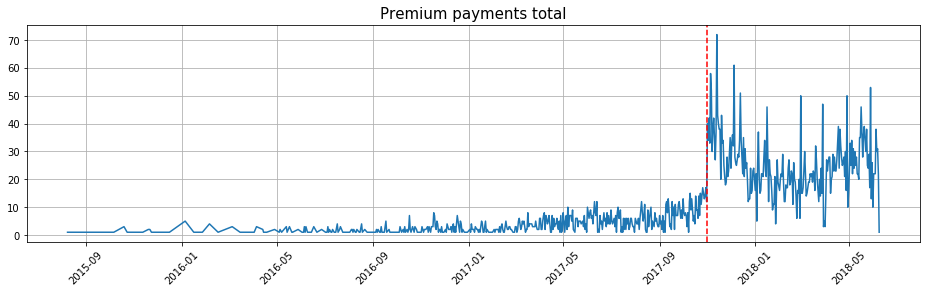

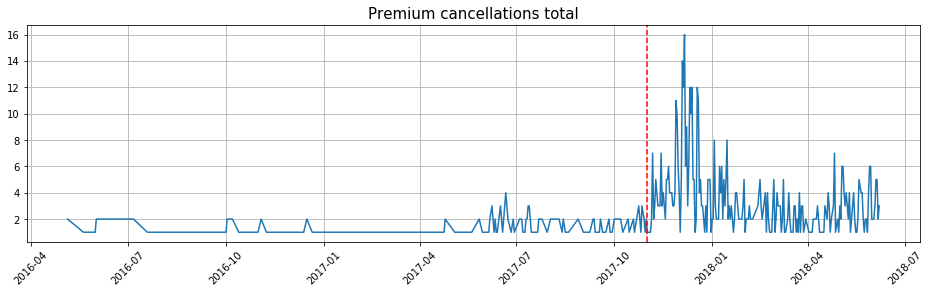

In [21]:
date = datetime.datetime.strptime('2017-11-01', '%Y-%m-%d')

g = df_dict['premium_payments'].groupby('PaymentDate')
x = g.count().index
y = g.count()['StudentId'].values
plt.figure(figsize=[16, 4])
plt.plot(x, y)
plt.axvline(x=date, linestyle='--', color='red') 
plt.title('Premium payments total', fontsize=15)
plt.grid()
plt.xticks(rotation=45)
plt.show()

g = df_dict['premium_cancellations'].groupby('CancellationDate')
x = g.count().index
y = g.count()['StudentId'].values
plt.figure(figsize=[16, 4])
plt.plot(x, y)
plt.axvline(x=date, linestyle='--', color='red') 
plt.title('Premium cancellations total', fontsize=15)
plt.grid()
plt.xticks(rotation=45)
plt.show()

# 3. Dados demográficos

Toda a análise feita acima levou em conta o Brasil como uma região única, mas poderíamos fazer as análises individualmente, uma para cada estado, por exemplo. Em vez disso, iremos ver alguns fatos gerais sobre os dados em mãos.

In [23]:
def zonal_plot(shp_path, z_means, title, cmap='jet', col_pos=1):
    """
    Given a shapefile path shp_path and dataframe z_means, this function merges the map with the information given and 
    makes a plot. The image is saved to the disk with the name 'map_image.png'.

    By default this function uses the second column of the shapefile to make the join between the datasets. Be sure 
    that this is the adequate column to perform this operation.
    
    Inputs
    ------
    shp_path: str
        String with the path to the shapefile.
    z_means: dataframe
        A dataframe with the means of the regions.
    title: str
        Title of the image.
    cmap: str
        String for the colormap.   
    col_pos: int
        Number of the column with the region names. Default is 1 (the second column).
    """

    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        """
        Given a colormap cmap and a interval contained in [0,1], this function truncates the colormap to the interval
        with n points.
        """

        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    # Load shapefile.
    dataset_map = gpd.read_file(shp_path)
    # Merge the shapefile with the dataframe of the means obtained from the raster data.
    column_name = dataset_map.columns[col_pos]
    merged = dataset_map.set_index(column_name).join(z_means)
    # Set a variable that will call whatever column we want to visualise on the map.
    variable = z_means.columns[0]
    # Convert column of interest to numeric type.
    merged[variable] = pd.to_numeric(merged[variable])
    # Set the range.
    vmin, vmax = np.nanmin(merged[variable]), np.nanmax(merged[variable])
    # Make the truncation.
    cmap = plt.get_cmap(cmap, 8)
    new_cmap = truncate_colormap(cmap, 0.4, 1.0)
    # Create figure and axes for Matplotlib.
    fig, ax = plt.subplots(1, figsize=(18, 8))
    # Create map.
    merged.plot(column=variable, cmap=new_cmap, linewidth=0.8, ax=ax, edgecolor='0.8')
    # Remove the axis.
    ax.axis('off')
    # Add a title.
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
    # Create colorbar as a legend.
    sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # Empty array for the data range.
    sm._A = []
    # Add the colorbar to the figure.
    cbar = fig.colorbar(sm)
    # Save image.
    #fig.savefig("map_image.png", dpi=300)

    return

A primeira coisa óbvia a se observar é o número de estudantes registrados por estado, isto nos dá uma ideia geral do quanto a Passei Direto atua em cada lugar. Não é surpresa que o Rio de Janeiro é o estado com o maior número de registros, seguido de São Paulo e depois Minas Gerais. Com exceção da Bahia, as regiões com mais registros são o sul e sudeste do Brasil. Certamente existe um grande número de estudantes no restante do país que podem ser potenciais clientes da Passei Direto. Há bastante espaço para crescimento ainda, basta saber como atuar nessas áreas de maneira mais efetiva.

/home/felipe/anaconda3/envs/satelite2/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


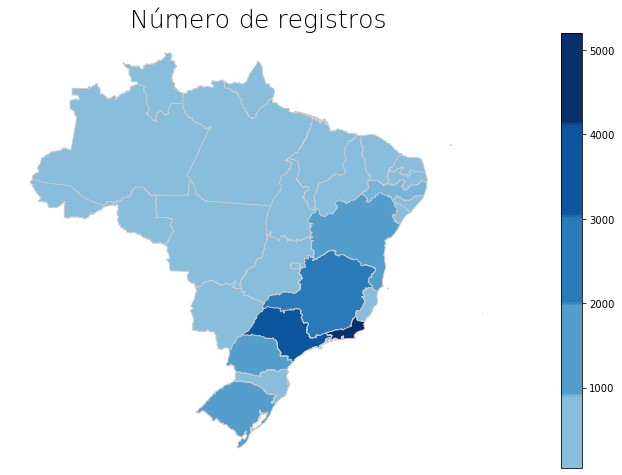

In [24]:
state_counts = pd.DataFrame(df_dict['students']['State'].value_counts())
shp_path = 'Brasil/UFEBRASIL.shp'
index = state_counts.index
new_index = state_counts.index.str.upper()
state_counts = state_counts.rename(index={index[i]: new_index[i] for i in range(len(index))})
zonal_plot(shp_path, state_counts, 'Número de registros', cmap='Blues', col_pos=2)

Mais interessante que o número total de registros é o número total de alunos com plano premium. Isto nos dá uma ideia de quais lugares estão dando mais retorno até agora. 

/home/felipe/anaconda3/envs/satelite2/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


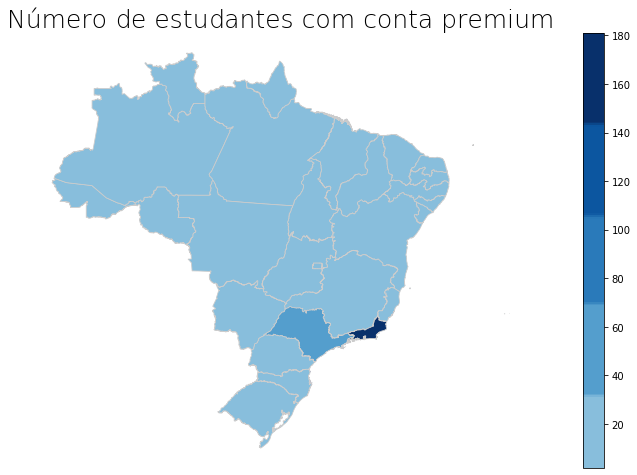

In [25]:
counts = merged[['State', 'StudentId']].groupby('State').count()
shp_path = 'Brasil/UFEBRASIL.shp'
index = counts.index
new_index = counts.index.str.upper()
counts = counts.rename(index={index[i]: new_index[i] for i in range(len(index))})
zonal_plot(shp_path, counts, 'Número de estudantes com conta premium', cmap='Blues', col_pos=2)

Os ganhos maiores com o Rio de Janeiro se devem bastante ao número de alunos registrados na plataforma, mas no quesito *fidelidade* (tempo usando o plano premium) as coisas mudam. Se tomarmos a média dos dias de plano premium por aluno, diversos estados começam a aparecer. Infelizmente isto pode ser apenas uma coincidência, pois na maior parte dos casos há poucos alunos para de fato termos uma média representativa. Por exemplo, Mato Grosso, que é o primeiro colocado, possui apenas 8 alunos. Como 6 destes alunos ficaram bastante tempo no plano premium, a média acabou ficando muito alta. Por um lado isto pode ser apenas consequência do baixo número de alunos para termos uma estatística representativa, por outro lado isto pode ser uma pequena amostra de um estado que tem mais tendência a permanecer mais tempo no plano premium. 

/home/felipe/anaconda3/envs/satelite2/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


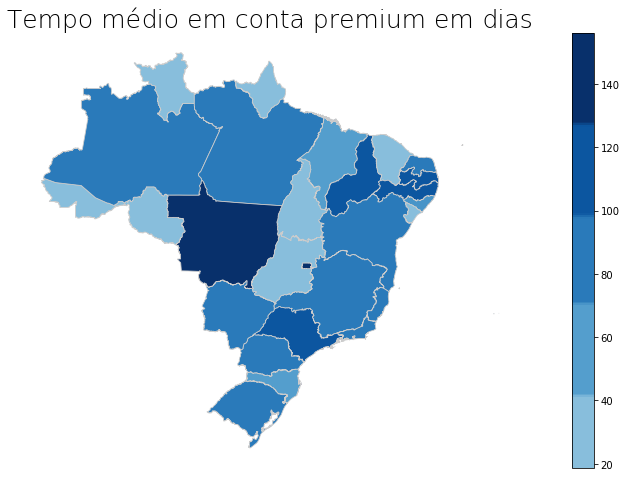

In [26]:
mean_time = merged[['State', 'StudentTime']].groupby('State').mean()
shp_path = 'Brasil/UFEBRASIL.shp'
index = mean_time.index
new_index = mean_time.index.str.upper()
mean_time = mean_time.rename(index={index[i]: new_index[i] for i in range(len(index))})
zonal_plot(shp_path, mean_time, 'Tempo médio em conta premium em dias', cmap='Blues', col_pos=2)

# 4. Experiência na plataforma

**Sobre a questão 3:** Depois de um tempo experimentando a plataforma Passei Direto, está claro que ela não se trata de apenas um repositório de materias didáticos, da mesma maneira que o Youtube não é apenas um repositório de vídeos. Ali há um espaço para as pessoas divulgarem seus trabalhos, de maneira personalizada. Para mim a analogia com o Youtube faz sentido, mas não precisa parar aí. Como acadêmico, sou sedento por artigos, e como a plataforma tem espaço para pós-graduandos, acho que seria natural também incorporar algo semelhante ao Google Scholar. Mais precisamente, um ambiente com a possibilidade de divulgação de artigos, saindo um pouco do aspecto didático da plataforma e indo para o lado da pesquisa. Atualmente eu (e mais um pequeno grupo) modero um grupo de Física e Matemática no Facebook com quase 100 mil memebros. Todos na moderação são atuantes tanto na questão didática quanto na de pesquisa, e nós ja tentamos criar um fórum brasileiro para uma troca mais séria de ideias acadêmicas, e não conseguimos. Também tentamos algo na plataforma Stack Exchange, e também acabou não vingando. Como erámos um bando de matemáticos e físicos amadores na internet, resolvemos deixar isso pra lá. Porém, a coisa poderia ser diferente se a iniciativa não fosse dada por meros acadêmicos amadores. Sem contar que o espaço na Passei Direto não seria para todas as disciplinas. Se tudo correr bem, é possível termos um Google Scholar brasileiro dentro da Passei Direto. 

Um outro ponto que gostaria de fazer é o seguinte: em muitos lugares, tipo academias de dança, tem aquela coisa de fazer uma "aula experimental". Isto é, se você acaba de conhecer um local onde a ativadade *x* é ensinada, normalmente te deixam ter uma aula de graça para você sentir o gostinho de quero mais. Depois de me registrar e usar a Passei Direto por 5 minutos eu já atingi o limite do mês, não tive a chance de desfrutar da minha "aula experimental". Acho que seria interessante se no início houvesse algum tipo de regalia que não acabasse em 5 minutos, de modo que o usuário sentisse o que é ter um plano premium por um tempo razoável. 